In [1]:
import json
import os
import pickle

import matplotlib
import numpy as np
from skimage import feature, io, transform, util
from sklearn import model_selection

In [2]:
DATA_DIRECTORY = "data"
MEN_DIRECTORY = os.path.join(DATA_DIRECTORY, "men")
WOMEN_DIRECTORY = os.path.join(DATA_DIRECTORY, "women")
LABELS_FILENAME = os.path.join(DATA_DIRECTORY, "labels.jsonl")

In [3]:
paths: list[str] = []
labels: list[int] = []
with open(LABELS_FILENAME, "r") as f:
    for line in f:
        entry = json.loads(line)
        path = entry["image_url"]
        label = int(entry["label"])
        paths.append(path)
        labels.append(label)

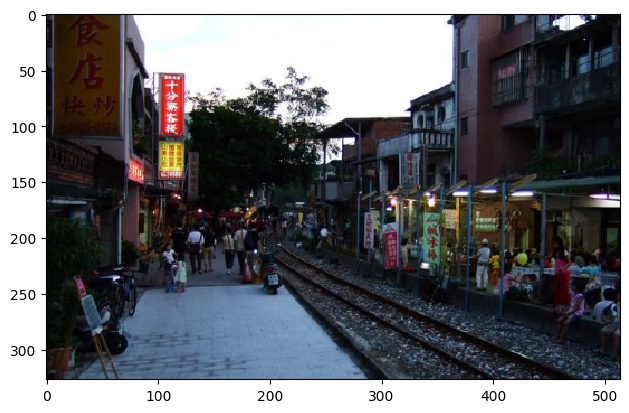

In [4]:
img = io.imread("test.jpg", as_gray=False)
io.imshow(img)


/home/cygnus/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/home/cygnus/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 39.92566095  47.24545763  57.53975519 255.        ]
  [ 64.88942682  64.84401916  68.32560677 255.        ]
  [ 41.60607023  25.07555644   9.24231956 255.        ]
  ...
  [ 25.47116285  35.55142868  40.52207779 255.        ]
  [ 13.66368851  16.90907105  22.9146306  255.        ]
  [  7.83063472  11.34243178  15.44606587 255.        ]]

 [[ 25.55305218  28.07292927  35.31776996 255.        ]
  [ 56.14130978  54.25553016  55.30033422 255.        ]
  [ 39.4858159   26.51851754   7.18414836 255.        ]
  ...
  [  9.87688026  11.0241583   13.06005019 255.        ]
  [  9.49270969  10.95924301  13.53019894 255.        ]
  [ 13.64379585  16.6027801   20.43199229 255.        ]]

 [[ 17.53388115  19.55134587  27.10108708 255.        ]
  [ 50.16985581  47.15107683  51.22646827 255.        ]
  [ 38.42999359  25.86599422   8.6073571  255.        ]
  ...
  [ 11.41357089  10.40211861  12.15862796 255.        ]
  [ 12.86152763  13.76266013  17.5425485  255.        ]
  [ 24.06998715  24.187243

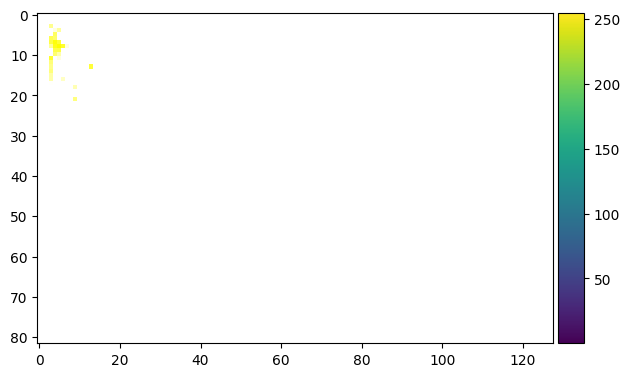

In [5]:
img = transform.rescale(img, 0.25, channel_axis=2) 
print(img) 
io.imshow(img)

In [6]:
from preprocessing import AMSR
p_img = AMSR(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


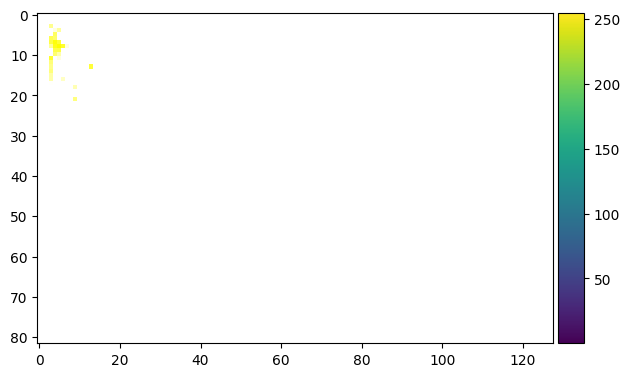

In [7]:
io.imshow(img)

[[[113 122 133 252]
  [142 141 144 252]
  [115  86  33 252]
  ...
  [ 89 107 113 253]
  [ 57  67  82 253]
  [ 29  46  61 254]]

 [[ 88  92 104 252]
  [133 130 130 252]
  [112  89  21 252]
  ...
  [ 40  45  53 253]
  [ 38  45  55 254]
  [ 57  66  76 254]]

 [[ 68  73  90 252]
  [126 122 126 252]
  [110  88  30 252]
  ...
  [ 47  42  49 253]
  [ 54  56  68 254]
  [ 87  86  96 254]]

 ...

 [[ 88  81  53 255]
  [ 92  80  67 254]
  [104  83  75 254]
  ...
  [104 123 140 254]
  [101 120 135 254]
  [109 127 142 254]]

 [[ 87  86  87 255]
  [110 106 109 254]
  [103  92  90 254]
  ...
  [117 132 149 254]
  [107 123 142 254]
  [104 123 141 254]]

 [[ 31  28  37 254]
  [ 57  40  49 254]
  [ 94  76  79 254]
  ...
  [103 121 135 254]
  [121 135 147 254]
  [132 142 159 254]]]


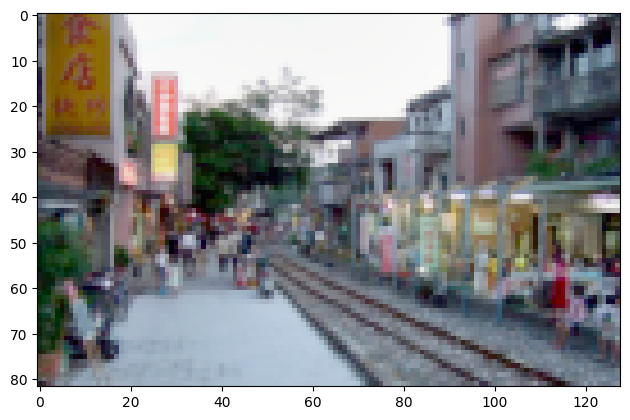

In [8]:
print(p_img)
io.imshow(p_img)

In [9]:
from hog import hog

myhog = hog
skhog = feature.hog


def get_features(img_path: str) -> np.ndarray:
    return np.random.rand(100)

    # read image as gray, floats, resized to half the dimensions
    img = util.img_as_float(io.imread(img_path, as_gray=True))
    # resize to half the dimensions
    img = transform.rescale(img, 0.5, anti_aliasing=True)

    features = myhog(img)

    return features

In [10]:
features = [get_features(path) for path in paths]

In [11]:
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)

In [12]:
# with open("features.pickle", "rb") as f:
# features = pickle.load(f)

In [13]:
random_state = 312

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    features, labels, test_size=0.2, random_state=random_state
)

In [14]:
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)

In [15]:
from sklearn.svm import SVC

clf = SVC(kernel="linear")

result = model_selection.cross_validate(
    clf,
    X_train,
    y_train,
    cv=cv,
    scoring=("accuracy", "balanced_accuracy"),
)

result

{'fit_time': array([0.28979564, 0.28167653, 0.26918769, 0.32740307, 0.3053863 ]),
 'score_time': array([0.03121305, 0.0300374 , 0.03181887, 0.02904296, 0.02936316]),
 'test_accuracy': array([0.15753425, 0.16838488, 0.1443299 , 0.17182131, 0.16151203]),
 'test_balanced_accuracy': array([0.15581461, 0.17295942, 0.14554034, 0.17319479, 0.16473914])}

In [16]:
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [17]:
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [18]:
# with open("model.pkl", "rb") as f:
#     clf = pickle.load(f)

In [19]:
clf.score(X_test, y_test)

0.1643835616438356